# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [57]:
import nltk.corpus
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [58]:
data = pd.read_csv('train.csv')

In [59]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [60]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [61]:
train.isna().sum() #убедились, что пропуски есть (в признаке location и keyword)

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [62]:
train = train.fillna('') #заменили NaN на пустую строку

In [63]:
train.isna().sum() #теперь пропусков нет

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [64]:
test.isna().sum() #убедились, что пропуски есть (в признаке location и keyword)

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [65]:
test = test.fillna('') #заменили NaN на пустую строку

In [66]:
train.head()

,id,keyword,location,text,target
1186,1707,bridge%20collapse,,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
4071,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
5461,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
5787,8257,rioting,,Still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [67]:
train.target.value_counts()

0    3024
1    2305
Name: target, dtype: int64

Таким образом, выборка сбалансированная. Нет сильного сдвига в количестве в сторону одного из классов, однако класса "0" больше.

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [68]:
train.keyword.value_counts() #посмотрим на колонку keyword и количество встречаемых значений:

                         44
damage                   36
siren                    35
wreckage                 34
fatalities               33
                         ..
rescue                   16
epicentre                10
radiation%20emergency     7
inundation                7
threat                    6
Name: keyword, Length: 222, dtype: int64

In [69]:
popular_keywords = train.keyword.value_counts().sort_values(ascending=False)[1:11].index.to_list() #взяли топ-10 значений без учета пустых значений (Пустые строки - наиболее встречаемые. На графике, изначально прикрепленном в условии этого задания значения пустой строки нет)
print(popular_keywords)

['damage', 'siren', 'wreckage', 'fatalities', 'deluge', 'emergency', 'harm', 'twister', 'nuclear%20reactor', 'fatality']


In [70]:
a = train[train.keyword.isin(popular_keywords)].groupby(['keyword', 'target']).size().unstack(fill_value=0)
a

target,0,1
keyword,,
damage,19,17
deluge,26,5
emergency,19,11
fatalities,17,16
fatality,22,8
harm,26,4
nuclear%20reactor,18,12
siren,31,4
twister,27,3


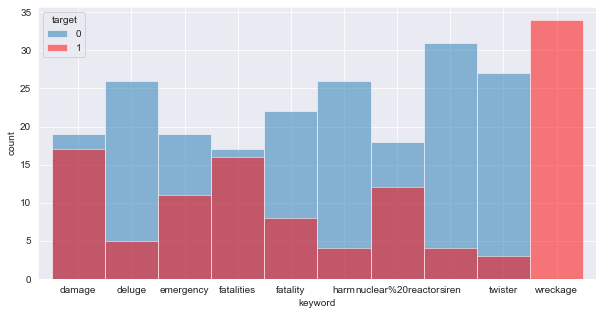

In [71]:
plt.figure(figsize=(10, 5))
a[0].plot.bar(alpha = .5, width = 1)
a[1].plot.bar(alpha = .5, color = 'red', width = 1)
#график построен именно таким образом, поскольку в задании гребуется столбчатая диаграмма (не гистограмма, хотя пример очень на нее похож - нет разделений между столбцами), в примере условия графики "наложены друг на друга", не stacked
plt.legend(['0', '1'], title = 'target')
plt.xticks(rotation = 'horizontal')
plt.ylabel('count')
plt.show()

**Выводы**: наиболее встречаемое значение "wreckage" - является показателем того, что в сообщении действительно идет ресь о катастрофе (все значения целевой переменной - 1). Значения fatalities и damage имеют небольшие отклонения между target = 1 и target = 0, следовательно, опираться только на эти значения нельзя. Twister и siren чаще всего используются не в контексте катастроф. (Может, сообщение со словом twister - об игре.)
Также по графику видно, что, на самом деле, сообщений НЕ о несчастных случаях больше (как бы уже убедились в этом ранее).

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [72]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [73]:
# -- YOUR CODE HERE --
train = train.drop(['id'], 1)
train['text'] = train[['keyword', 'location', 'text']].apply(' '.join, axis = 1)
train_new = train.drop(['keyword', 'location'], 1)


C:\Users\81E4~1\AppData\Local\Temp/ipykernel_14072/1431447347.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train = train.drop(['id'], 1)
C:\Users\81E4~1\AppData\Local\Temp/ipykernel_14072/1431447347.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_new = train.drop(['keyword', 'location'], 1)


In [74]:
test = test.drop(['id'], 1)
test['text'] = test[['keyword', 'location', 'text']].apply(' '.join, axis = 1)
test = test.drop(['keyword', 'location'], 1)

C:\Users\81E4~1\AppData\Local\Temp/ipykernel_14072/2827435259.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test = test.drop(['id'], 1)
C:\Users\81E4~1\AppData\Local\Temp/ipykernel_14072/2827435259.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test = test.drop(['keyword', 'location'], 1)


In [75]:
test.head()

,text,target
2644,destruction So you have a new weapon that can...,1
2227,deluge The f$&amp;@ing things I do for #GISHW...,0
5448,police UK DT @georgegalloway: RT @Galloway4May...,1
132,aftershock Aftershock back to school kick off...,0
6845,"trauma Montgomery County, MD in response to tr...",0


In [76]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [77]:
from sklearn.feature_extraction.text import CountVectorizer

# -- YOUR CODE HERE -- источник: семинар 11
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train_new['text'])

In [78]:
cnt_vec.vocabulary_.keys() #посмотрим на слова, используемые в текстах

dict_keys(['bridge', '20collapse', 'ashes', '2015', 'australia', 'ûªs', 'collapse', 'at', 'trent', 'among', 'worst', 'in', 'history', 'england', 'bundled', 'out', 'for', '60', 'http', 'co', 't5trhjuau0', 'hail', 'carol', 'stream', 'illinois', 'great', 'michigan', 'technique', 'camp', 'b1g', 'thanks', 'to', 'bmurph1019', 'hail_youtsey', 'termn8r13', 'goblue', 'wrestleon', 'oaskgki6qj', 'police', 'houston', 'cnn', 'tennessee', 'movie', 'theater', 'shooting', 'suspect', 'killed', 'by', 'di8elzswnr', 'rioting', 'still', 'couple', 'of', 'hours', 'left', 'until', 'have', 'be', 'up', 'class', 'wounds', 'lake', 'highlands', 'crack', 'the', 'path', 'where', 'wiped', 'this', 'morning', 'during', 'beach', 'run', 'surface', 'on', 'elbow', 'and', 'right', 'knee', 'yaqrsximph', 'airplane', '20accident', 'somewhere', 'there', 'experts', 'france', 'begin', 'examining', 'debris', 'found', 'reunion', 'island', 'french', 'air', 'accident', 'tagzbcxfj0', 'mlb', 'bloody', 'isolated', 'city', 'world', 'pert

In [79]:
len(cnt_vec.vocabulary_.keys()) #количество встречаемых слов

18455

In [80]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [81]:
X.toarray().shape

(5329, 18455)

In [82]:
train_new.shape

(5329, 2)

Мы получили матрицу размером (5329, 18455). Действительно, всего 5239 объектов в train (то есть текстов) и 18455 слов, встречаемых в них. Матрица очень большая. Стоит попробовать применить лемматизацию,убрать стоп-слова для уменьшения ее размеров.


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [83]:
import re
from string import punctuation

In [84]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return bool(re.search(r'[0-9]', s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(x in punctuation for x in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', len({k:v for k, v in vocabulary.items() if contains_digit(k)})
          )
    print('With punctuation:', len({k:v for k, v in vocabulary.items() if contains_punctuation(k)})
          )
    print('Hashtags:        ', len({k:v for k, v in vocabulary.items() if is_hashtag(k)})
          )
    print('Mentions:        ', len({k:v for k, v in vocabulary.items() if is_mention(k)})
          )




In [85]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [86]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


Таким образом, мы видим, что CountVectorizer убирает хэштеги и упоминания автоматически, а именно для нашего датасета они могут иметь большое значение при предсказаниях.

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [87]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [88]:
help(TweetTokenizer)

Help on class TweetTokenizer in module nltk.tokenize.casual:

class TweetTokenizer(builtins.object)
 |  TweetTokenizer(preserve_case=True, reduce_len=False, strip_handles=False, match_phone_numbers=True)
 |  
 |  Tokenizer for tweets.
 |  
 |      >>> from nltk.tokenize import TweetTokenizer
 |      >>> tknzr = TweetTokenizer()
 |      >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
 |      >>> tknzr.tokenize(s0)
 |      ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3'
 |      , 'and', 'some', 'arrows', '<', '>', '->', '<--']
 |  
 |  Examples using `strip_handles` and `reduce_len parameters`:
 |  
 |      >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
 |      >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
 |      >>> tknzr.tokenize(s1)
 |      [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
 |  
 |  Methods defined here:
 |  
 |  __init__(self, preserve_case=True, reduce_len=F

In [89]:
cnt_tweet = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
X_tweet = cnt_tweet.fit_transform(train_new['text'])
X_tweet.shape
#b = vec.fit_transform(t for t in texts_tokenized)

D:\programs\anaconda3\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 19670)

Видим,что количество слов увеличилось.

In [90]:
investigate_vocabulary(cnt_tweet.vocabulary_
                       )

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** Таким образом, токенизатор, стоящий по умолчанию в CountVectorizer, выдает меньший словарь, не воспринимает хэштеги, упоминания, в отличие от TweetTokenizer. Для обработки  наших данных определенно лучше подойдет TweetTokenizer, поскольку хэштеги, упоминания, смайлики могут имет значительный вес.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [91]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [92]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return not bool(re.search(r'[^a-zA-Z]', s))

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return (all(x in punctuation for x in s) and any([j in ['(', ')', '[', ']', ] for j in s]))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return (s.startswith('#') and contains_only_latin_letters(s[1:]))

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    s = s.lower() #0
    tokenised_s = TweetTokenizer().tokenize(s) #1
    cleaned_s = list(filter(lambda i: (contains_only_latin_letters(i) or is_emoji(i) or is_hashtag(i)), tokenised_s)) #2
    cleaned_s = [x for x in cleaned_s if x not in stopwords.words('english')] #3
    stemmer = SnowballStemmer("english") # из материалов семинара 11
    text_stemmed = [stemmer.stem(w) for w in cleaned_s] #4
    return text_stemmed

In [93]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [94]:
# -- YOUR CODE HERE --
for i in train_new.text[:10]:
    print(custom_tokenizer(i))
    print(i, '\n')

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0 

['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj 

['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR 

['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
rioting  Still rioting in a couple of hours left until I have to be up for class. 

['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left',

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [95]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

bow = vectorizer.fit_transform(train_new.text)
bow_test = vectorizer.transform(test.text)

In [96]:
from sklearn.preprocessing import MaxAbsScaler

In [97]:
#scaler = MaxAbsScaler()
#bow = scaler.fit_transform(bow)
#bow_test = scaler.transform(bow_test)

|2. Обучите LogisticRegression на полученных признаках.


In [98]:
from sklearn.linear_model import LogisticRegression
# -- YOUR CODE HERE --
clf = LogisticRegression().fit(bow, train_new.target)

3. Посчитайте метрику f1-score на тестовых данных.

In [99]:
from sklearn.metrics import f1_score
prediction = clf.predict(bow_test)
print('F1-score:', f1_score(test.target, prediction))

F1-score: 0.7526881720430109


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
train_tf = tfidf_vec.fit_transform(train_new.text)
test_tf = tfidf_vec.transform(test.text)

clf = LogisticRegression().fit(train_tf, train_new.target)
print('F1-score for tf-idf:', f1_score(test.target, clf.predict(test_tf)))

D:\programs\anaconda3\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1-score for tf-idf: 0.7412353923205343


1. **Ответ:** Мы видим, что качество на TF-IDF хуже, чем на Bag-of-words. Из семинаров мы узнали, что на малых данных BOW, действительно, работает лучше.

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [101]:
# 2
# -- YOUR CODE HERE --
tfidf_vec1 = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=.9)
X_train_tf1 = tfidf_vec1.fit_transform(train_new.text)
X_test_tf1 = tfidf_vec1.transform(test.text)

clf = LogisticRegression().fit(X_train_tf1, train_new.target)

D:\programs\anaconda3\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [102]:
# -- YOUR CODE HERE --
print('Размер матрицы с исп-ем TF-IDF:', train_tf.toarray().shape)
print('Размер матрицы с использованием TF-IDF и порогом .9:', X_train_tf1.toarray().shape)
print('F1-score for tf-idf:', f1_score(test.target, clf.predict(X_test_tf1)))

Размер матрицы с исп-ем TF-IDF: (5329, 10484)
Размер матрицы с использованием TF-IDF и порогом .9: (5329, 10484)
F1-score for tf-idf: 0.7412353923205343


2. **Ответ:** Размер матрицы не изменился. Качество тоже осталось прежним. Это означает, что слов, встречаемых в 90% текстов, нет или их очень мало. Это могли бы быть стоп-слова, но мы их убрали.

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [103]:
# 3
i =.0001
tfidf_vec2 = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=i)
X_train_tf2 = tfidf_vec2.fit_transform(train_new.text)
X_test_tf2 = tfidf_vec2.transform(test.text)

scaler = MaxAbsScaler()
X_train_tf2 = scaler.fit_transform(X_train_tf2)
X_test_tf2 = scaler.transform(X_test_tf2)

clf = LogisticRegression().fit(X_train_tf2, train_new.target)

print(f'Размер матрицы с использованием TF-IDF и минимальным df = {i}:', X_train_tf2.toarray().shape)
print('F1-score for tf-idf:', f1_score(test.target, clf.predict(X_test_tf2)))

D:\programs\anaconda3\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Размер матрицы с использованием TF-IDF и минимальным df = 0.0001: (5329, 10484)
F1-score for tf-idf: 0.74400871459695


3. **Ответ:** Мы рассмотрели различные значения min_df. Удалось уменьшить размер матрицы, а также немного улучшить качество. То есть,мы убрали слова очень редко встречаемые в текстах, а именно с частотой 0.01%.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [104]:
from sklearn.feature_extraction.text import HashingVectorizer
hash_vec = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
hash = hash_vec.fit_transform(train_new.text)
hash_test = hash_vec.transform(test.text)

clf = LogisticRegression().fit(hash, train_new.target)

D:\programs\anaconda3\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [105]:
print(f'Размер матрицы с использованием hashing trick:', hash.toarray().shape)
print('F1-score:', f1_score(test.target, clf.predict(hash_test)))

Размер матрицы с использованием hashing trick: (5329, 5000)
F1-score: 0.7197771587743732


Качество хуже, чем у tf-idf, но размер матрицы явно меньше с таким способом (5000 - как мы и установили).

2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Самый высокий результат показал BOW.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

При BOW f1 уже достигло .75 на тестовых данных. Попробуем увеличить его. Будем использовать изученный метод опорных векторов, а также scaler. С svm вероятности предсказываются хуже, определение к классу - лучше, поэтому метрики могут быть лучше.

In [106]:
# -- YOUR CODE HERE --
bow1 = bow

scaler = MaxAbsScaler()
bow2 = scaler.fit_transform(bow)
bow_test2 = scaler.transform(bow_test)

from sklearn.svm import SVC
svm_rbf = SVC(kernel="rbf", probability=True)
svm_rbf.fit(bow, train_new.target)
svm_rbf_y_pred = svm_rbf.predict(bow_test)
print('F1-score for svm-rbf:', f1_score(test.target, svm_rbf_y_pred))

from sklearn.svm import SVC
svm_rbf = SVC(kernel="rbf", probability=True)
svm_rbf.fit(bow2, train_new.target)
svm_rbf_y_pred = svm_rbf.predict(bow_test2)
print('F1-score for svm-rbf with scaler:', f1_score(test.target, svm_rbf_y_pred))

F1-score for svm-rbf: 0.74230330672748
F1-score for svm-rbf with scaler: 0.7162567486502699


In [107]:
svm_lin = SVC(kernel="linear", probability=True)
svm_lin.fit(bow, train_new.target)
svm_lin_y_pred = svm_lin.predict(bow_test)
print('F1-score for svm-linear:', f1_score(test.target, svm_lin_y_pred))

svm_lin = SVC(kernel="linear", probability=True)
svm_lin.fit(bow2, train_new.target)
svm_lin_y_pred = svm_lin.predict(bow_test2)
print('F1-score for svm-linear with scaler:', f1_score(test.target, svm_lin_y_pred))

F1-score for svm-linear: 0.722457627118644
F1-score for svm-linear with scaler: 0.7211538461538461


In [108]:
svm_sigm = SVC(kernel="sigmoid", probability=True)
svm_sigm.fit(bow, train_new.target)
svm_sigm_y_pred = svm_sigm.predict(bow_test)
print('F1-score for svm-sigmoid:', f1_score(test.target, svm_sigm_y_pred))

svm_sigm = SVC(kernel="sigmoid", probability=True)
svm_sigm.fit(bow2, train_new.target)
svm_sigm_y_pred = svm_sigm.predict(bow_test2)
print('F1-score for svm-sigmoid with scaler:', f1_score(test.target, svm_sigm_y_pred))

F1-score for svm-sigmoid: 0.7434903047091412
F1-score for svm-sigmoid with scaler: 0.7391304347826086


In [109]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(bow, train_new.target)
knn_y_pred = knn.predict(bow_test)
print('F1-score for knn:', f1_score(test.target, knn_y_pred))

knn = KNeighborsClassifier()
knn.fit(bow2, train_new.target)
knn_y_pred = knn.predict(bow_test2)
print('F1-score for knn with scaler:', f1_score(test.target, knn_y_pred))

F1-score for knn: 0.578811369509044
F1-score for knn with scaler: 0.3299319727891157


Таким образом, модель, полученная в задании 8 -лучшая:

In [110]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

bow = vectorizer.fit_transform(train_new.text)
bow_test = vectorizer.transform(test.text)

clf = LogisticRegression().fit(bow, train_new.target)

prediction = clf.predict(bow_test)
print('best F1-score:', f1_score(test.target, prediction))

D:\programs\anaconda3\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


best F1-score: 0.7526881720430109
